"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
import pandas as pd

sys.path.append('/media/bigdata/projects/pytau')
import pytau

import itertools as it
from tqdm import tqdm

In [3]:
data_dir = '/media/fastdata/DS39_spont_taste_201029_154308'
dat = ephys_data(data_dir)
dat.get_spikes()

In [23]:
# spike_array :: Tastes x trials x nrns x time_bins
spikes=np.array(dat.spikes[:4])
time_lims = [2000,4000]
spikes = spikes[...,time_lims[0]:time_lims[1]]
print(spikes.shape)

(4, 30, 87, 2000)


In [26]:
bin_width = 50
spike_array = np.sum(np.reshape(spikes,(*spikes.shape[:3],-1,bin_width)),axis=-1)
print(spike_array.shape)

(4, 30, 87, 40)


In [52]:
# fig, ax = plt.subplots(6,5, figsize = (15,10))
# for this_dat, this_ax in zip(spike_array[0], ax.flatten()):
#     this_ax.imshow(stats.zscore(this_dat,axis=-1), interpolation='nearest', aspect='auto')

In [30]:
state_list = range(2,7)
comps_list = range(2,4)
iters = list(it.product(state_list, comps_list))

In [33]:
elbo_list = []
model_list = []
approx_list = []
fit = 40000
samples = 20000

In [34]:
#all_taste_poisson_trial_switch(spike_array,switch_components,states)
for this_iter in tqdm(iters):
    model = pytau.changepoint_model.all_taste_poisson_trial_switch(spike_array, this_iter[1], this_iter[0])
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        #trace = approx.sample(draws=samples)
        
    model_list.append(model)
    approx_list.append(approx)
    elbo_list.append(-approx.hist[-1])
        



  0%|          | 0/10 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6842e+05


 10%|█         | 1/10 [10:56<1:38:29, 656.56s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6828e+05


 20%|██        | 2/10 [22:02<1:27:54, 659.34s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6753e+05


 30%|███       | 3/10 [35:03<1:21:11, 695.88s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6762e+05


 40%|████      | 4/10 [48:21<1:12:38, 726.38s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6713e+05


 50%|█████     | 5/10 [1:03:34<1:05:12, 782.55s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6757e+05


 60%|██████    | 6/10 [1:18:46<54:45, 821.38s/it]  INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6714e+05


 70%|███████   | 7/10 [1:35:18<43:37, 872.56s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6783e+05


 80%|████████  | 8/10 [1:52:26<30:38, 919.17s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6726e+05


 90%|█████████ | 9/10 [2:11:01<16:17, 977.75s/it]INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


Finished [100%]: Average Loss = 2.6782e+05


100%|██████████| 10/10 [2:29:50<00:00, 899.07s/it] 


In [35]:
param_array = np.array(iters)
elbo_frame = pd.DataFrame(dict(
                states = param_array[:,0],
                components = param_array[:,1],
                elbo = elbo_list))

## ==== Models with Top 3 ELBO ====

In [36]:
elbo_frame.sort_values('elbo', ascending=False).head(3)

,states,components,elbo
4,4,2,-266999.018958
8,6,2,-267273.315314
6,5,2,-267280.726156


In [40]:
best_model_ind = np.argmax(elbo_list)
best_model = model_list[best_model_ind]
best_approx = approx_list[best_model_ind]

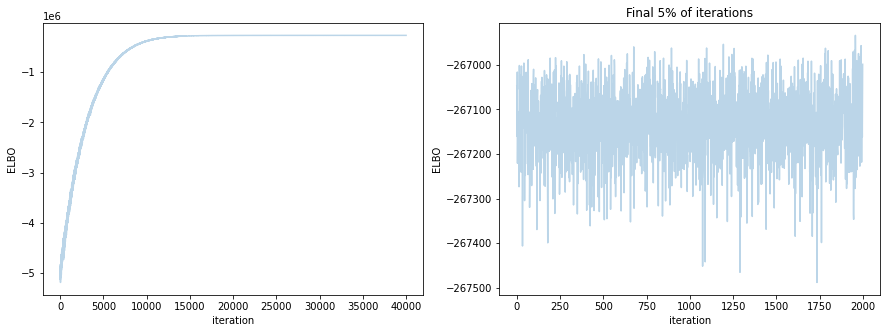

In [42]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-best_approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-best_approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [41]:
with best_model:
    trace = best_approx.sample(draws=samples)

INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.13-64/lock_dir/lock


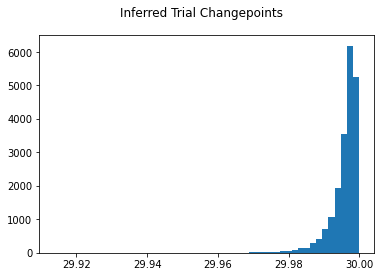

In [43]:
for dist in trace['tau_trial'].T:
    plt.hist(dist,bins = 50);
plt.suptitle('Inferred Trial Changepoints');

In [44]:
ppc = pm.sample_posterior_predictive(trace, samples = 200, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [47]:
ppc['obs'].shape

(200, 4, 30, 87, 40)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


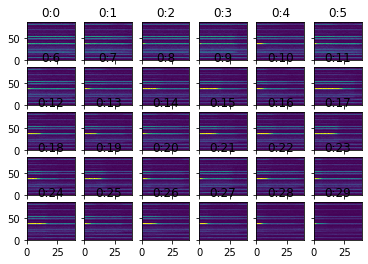

In [46]:
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[0],cmap='viridis');